In [1]:
import os, sys
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('final_project')))
sys.path.append(parent_dir)

from social_network_algorithms.mining.diameter import stream_diam
from lesson5 import *
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import networkx as nx

# Utilities
Utility class to print networks' degrees' distribution.

In [2]:

class Analyzer:
    
    def __init__(self, network):
        self.network = network
        
    def get_degree_distribution(self):
        "Returns the plot of the degree distribution with a log-log scale"
        
        N = self.network.number_of_nodes()
        degrees = [self.network.in_degree(n) for n in self.network.nodes()] if self.network.is_directed() else [self.network.degree(n) for n in self.network.nodes()]
        
        N_k = {}
        for k in degrees:
            if k not in N_k:
                N_k[k] = 1
            else:
                N_k[k] += 1
                
        p_k = {}
        for k in N_k:
            p_k[k] = N_k[k] / N
        
        # Plotting in log-log scale
        plt.figure(figsize=(8, 6))
        plt.loglog(list(p_k.keys()), list(p_k.values()), marker='o', linestyle='None', color='b')
        plt.title('Log-log Degree Distribution')
        plt.xlabel('Degree')
        plt.ylabel('Frequency')
        plt.grid(True)

        return plt
    
    def get_degree_distribution_axes(self):
        "Returns the axes of the degree distribution with a log-log scale"
        
        N = self.network.number_of_nodes()
        degrees = [self.network.in_degree(n) for n in self.network.nodes()] if self.network.is_directed() else [self.network.degree(n) for n in self.network.nodes()]
        
        N_k = {}
        for k in degrees:
            if k not in N_k:
                N_k[k] = 1
            else:
                N_k[k] += 1
                
        p_k = {}
        for k in N_k:
            p_k[k] = N_k[k] / N
        
        plt.loglog(list(p_k.keys()), list(p_k.values()), marker='o', linestyle='None', color='b')
        plt.grid(True)

        return plt.gca()

# Our network
We first printed the degrees' distribution of our network.

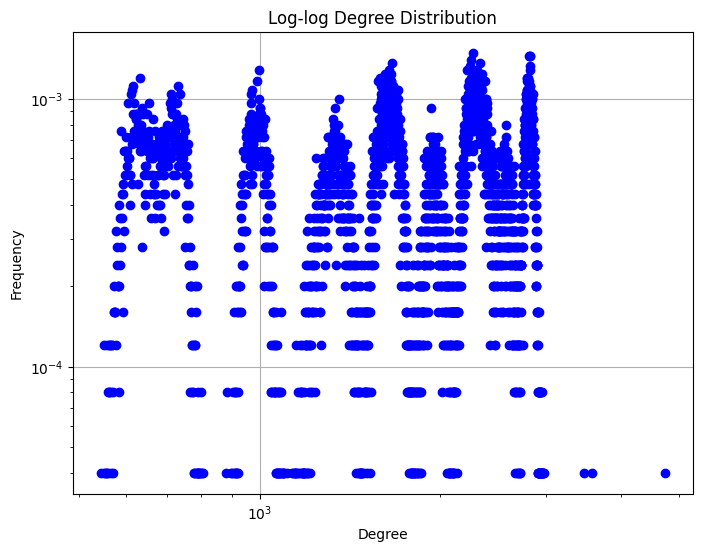

In [7]:
G = nx.read_edgelist('../net_2', nodetype=int)
net_analyzer = Analyzer(G)
net_analyzer.get_degree_distribution().show()

The number of nodes and edges of our network are:

In [19]:
print("Nodes: ", G.number_of_nodes())
print("Edges: ", G.number_of_edges())

Nodes:  25000
Edges:  23000065


Then we computed the diameter:

In [11]:
print('Diameter: ', stream_diam(G))

Diameter:  3


After that, we also checked the clustering coefficient, but it required too much time to run in local so we run it on Kaggle on another notebook for almost 8 hours and we obtained an average clustering coefficient of <b> 0.12 </b>. 

We also wanted to use a clustering algorithm to detect communities, if any, but, given the high number of edges of our network, the main algorithms which we selected did not finish to run at all, even in long periods of time. 

From the midterm homework, during which we tested the improved parallel algorithms on the suggested big networks, we shortlisted the Girvan Newman algorithm which, despite it took a significant amount of time, was still able to finish running in its euristic, parallel and sampled version. In this case, probabily due to the 100 * times greater number of edges, it was not able to finish at all and often coused workers to stop and ended up in memory leaks.

At the and, after a few researchs, we found the <b>Louvain</b> algorithm which was able to execute the community detection even on networks of these dimensions.

In [27]:
print("Number of communities: ", sum(1 for _ in nx.algorithms.community.louvain_communities(G)))

Number of communities:  4


This is an heuristic method based on modularity optimization. 
It works in two main steps:
<ol>
    <li> Assigns every node to be in its own community.</li>
    <li> For each node it tries to find the maximum positive modularity gain by moving each node to all of its neighbour communities. If no positive gain is achieved the node remains in its original community. </li>
</ol>

Executing more than one time the algorithm, we obtained different results in terms of found communities, but on the average it was 4 or 5.

Then we tried to find strongly connected components.

In [28]:
cc = nx.algorithms.components.connected_components(G)
print("Number of connected components: ", sum(1 for _ in cc))
for c in cc:
    print("Size of connected component: ", len(c))

Number of connected components:  1


We found out that the whole network was connected.

# Random Graphs
We first checked if the network was generated with the random graph model. We already knew from theory that the degree distribution of a random graph is Poisson-like so we expected that it had no chance to be similar to ours which has a completely different shape. After just an attempt we had the confirm that we were right. So we are able to exclude Random Graphs from the possible models which generated our network.

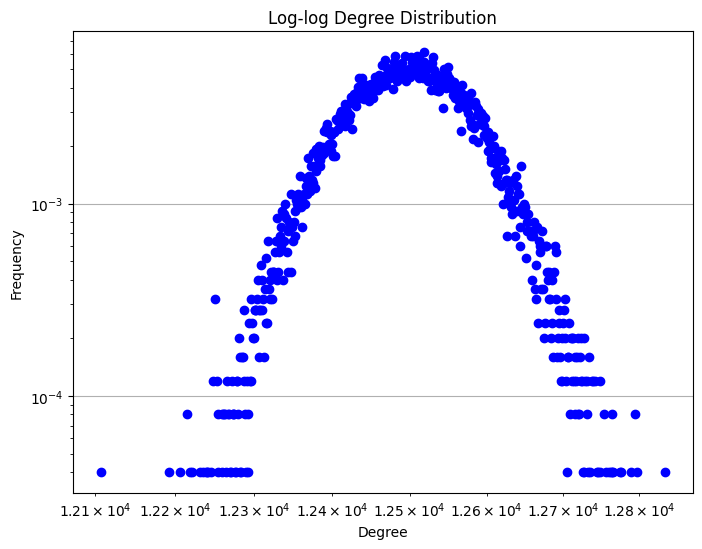

In [29]:
n = 25000

p = 0.5

g = randomG(n, p)
analyzer = Analyzer(g)
plt = analyzer.get_degree_distribution()
plt.show()

Also changing the value of p in the range [0, 1], we always obtained the same degree distribution, so we only report one attempt from clearness sakes.

# Configuration model
We started considering the fact that our degree distribution was not a power law, so it was not work to generate a power law distribution of degrees and to feed it to the configurationG algorithm to check the result, also because this algorithm is really <i>never ending</i> for our mean degrees' values and number of nodes.

Taken this into account, we though that taking our degree distribution and giving it to the algorithm was also not worth, because it would have copied the distribution and it would have not told us something new, so we decided to pass to the analysis of the other models.

# Preferential Attachment
To check if the network was generated using a preferential attachment model, we generated a preferential graph for n = 25000 with various values of p (from 0 (excluded) to 1 (included)) and plotted the degree distribution for each graph.

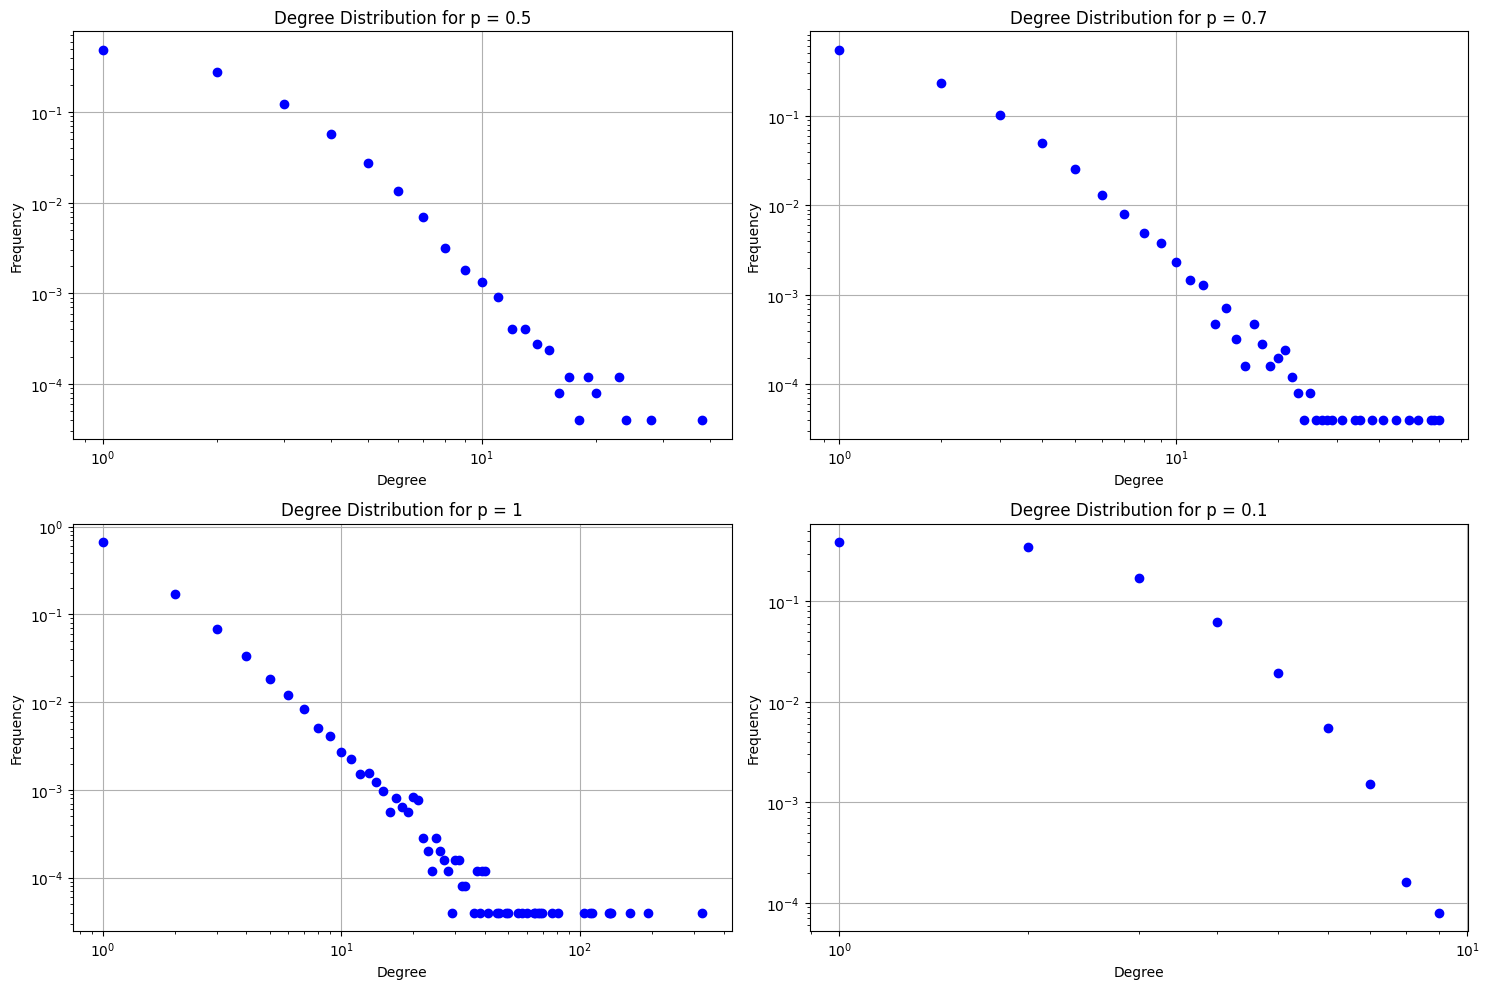

In [37]:
n = 25000

ps = [0.1, 0.5, 0.7, 1]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, p in enumerate(ps):
    row = i // 2
    col = i % 2
    g = preferentialG(n, p)
    analyzer = Analyzer(g)
    ax = analyzer.get_degree_distribution_axes()
    plt.sca(ax)  
    plt.grid(True)  
    plt.title('Degree Distribution for p = ' + str(p))
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    fig.add_subplot(axs[row, col]) 

plt.tight_layout()
plt.show()
    

From the plotted degrees' distributions for the different values of p we are able to see that it has the shape of a power law, which is not our case, so we are able to exclude it in the first place.

# Generalized Watts-Strogatz

First of all in this model the number of nodes must be a perfect square, otherwise it is approzimated to the closest perfect square. Our number of nodes is 25000 which is not a perfect square, so it's not been approximated and this could be sufficient to exlude this model.
We have to provide to the model the number of nodes, the radius of each node (which is the number of strong ties) and the number of weak ties. q is used to evaluate how much the distance matters (0 -> weak ties are placed uniformely, \infin -> place weak ties towards neighbors).

In [40]:
# Generate the small graph
small_graph = GenWS2DG(25000, 1, 1, 0.1)

# Compute the degree distribution of the small graph
analyzer_g2 = Analyzer(small_graph)
plt = analyzer_g2.get_degree_distribution()
plt.show()

: 

We tried several attempt with this number of nodes, but it takes a very long time and the kernel crushes, so we decide not to take it into consideration based on the previously mentioned observation about the perfect squares.

# Affiliation Networks
Excluded all the previous options, we passed to the affiliation networks, where:
<ul>
    <li>n = number of nodes</li>
    <li>m = number of communities</li>
    <li>q = probability of preferential affiliation to communities</li>
    <li>c = maximum number of communities to which one node may be affiliated</li>
    <li>p = probability of an inter-community edge (strong ties)</li>
    <li>s = number of out-community edges (weak ties)</li>
</ul>

After making a few attempts, we saw that the shape of the degree distribution was similar to ours in many different runs, except for the scale, ...
So we decided to furtherly investigate the model and try to estimate the parameters in order to get a distribution which was similar to ours and a network with similar clustering coefficient, number of commuities, number of strongly connected components, etc.

In [5]:
avg_degree_G = int(sum(dict(G.degree()).values()) / len(G))
print(avg_degree_G)

1840


Before going on, we have to say something about the estimate of the number of weak ties s. Since in the provided code, there was an error in the last part, adding weak ties to the model, we noticed that for each node i the same edge with a node j (coming from the previous loop adding strong ties) was added s times, this means that there's at most 1 weak tie for each node in the generated model (independently from the specified parameter s).

## Communities

First we tried to estimate the total number of communities (m) and the maximum number of communities a node is affiliated to (c). This model allows a node to be affiliated to more than one community so a classical community detection algorithm like the Louvain one, previously mentioned, is not well suited for our purposes, despite it is the only one which ends on our network.

First we tried to follow the BigCLAM approach (which can be found in the "Community-Affiliation Graph Model for Overlapping Network Community Detection" paper by Stanford University). Our implementation can be found in the BigCLAM.py file. We basically tried to estimate the probability of affiliation of a given node to a community and, depending on it, estimate m and c. It was basically a generative approach which wanted to estimate the probabilities of affiliation, extract m and c, and use them to generate a new model, evaluate "how close" was the model to ours and then terminate when a similar model was reached. 
Despite this, we were not able to test it on this network because it did not end, due to its dimensions.

A second try was made trying to found something which could finally converge and give us an usable result. Since Louvain converged in a reasonable amount of time, we searched for something related to it usable also for overlapping community and we found the "A Fast Algorithm for Overlapping Community Detection" paper by Elyasi, Meybodi, Rezvanian, Haeri. 

They use an approach in 3 steps:
<ol>
    <li>Apply Louvain n times, it will give n different results.</li>
    <li>Build a belonging matrix of each node to each community.</li>
    <li>Use a greedy approach to merge similar communities and compute the Nicosia modularity to check the quality of the partition.</li>
</ol>

We were inspired by this work, but we had to change something about the third point. As a matter of fact, it would have taken too much time to do it repeadetly also on the merged communities and so on. For our implementation check overlapping_louvain.py. The following code is what we used in reality to compute m and c, also based on the evidence of the produced belonging_matrix.txt.


In [4]:
import networkx as nx

def operlapping_louvain(G, n_iter = 2):
    
    # STEP 1. execute the louvain algorithm n_iter times and record the results
    results = []
    for i in range(n_iter):
        results.append([])
        communities = nx.community.louvain_communities(G)   
        for community in communities:
            results[i].append(community)
            
    mean_len = sum([len(row) for row in results]) / len(results)

    # STEP 2. build the belonging matrix with N rows (number of nodes) and C columns (number of communities)
    n_nodes = len(G.nodes())
    
    # initialize the belonging matrix, each node ia a community
    belonging_matrix = [[0 for _ in range(n_nodes)] for _ in range(n_nodes)]

    # fill the belonging matrix
    for row in results:
        for i, community in enumerate(row):
            for node in community:
                for neighbor in G.neighbors(node):
                    if neighbor in community:
                        belonging_matrix[node][i] += 1
                          
    # normalize the belonging matrix in range [0,1] to compute the belonging coefficient of each node to each community
    # take the maximum coefficient of the whole matrix
    max_coefficient = max([max(row) for row in belonging_matrix])
    for row in belonging_matrix:
        for i in range(len(row)):
            row[i] /= max_coefficient
            
    # take non null elements of the belonging matrix
    non_null_elements = []
    for row in belonging_matrix:
        for element in row:
            if element > 0:
                non_null_elements.append(element)
    
    # compute lambda_
    lambda_ = sum(non_null_elements)/len(non_null_elements)
    print("lambda:", lambda_)
    
    # if the coefficient is greater than lambda_ then the node belongs to the community
    communities = {i: set() for i in range(n_nodes)}
    i = 1
    for node in belonging_matrix:
        for j in range(n_nodes):
            if node[j] > lambda_:
                communities[j].add(i)
        i += 1
        
    # remove empty communities
    for community in list(communities.keys()):
        if len(communities[community]) == 0:
            communities.pop(community)
            
    print("Number of communities:", len(communities))

    return communities, belonging_matrix, lambda_, mean_len

In [5]:
communities, belonging_matrix, lambda_, mean_len = operlapping_louvain(G, 50)
print("Mean length:", mean_len)
# save the belonging matrix in a file
belonging_matrix_file = open("belonging_matrix.txt", "w")
for row in belonging_matrix:
    belonging_matrix_file.write(str(row) + "\n")
belonging_matrix_file.close()

lambda: 0.27731050322220085
Number of communities: 4
Mean length: 4.0


In [9]:
for community in communities:
    print(community, len(communities[community]))

0 14170
1 14171
2 11728
3 3527


### Compute m

In [7]:
# m = mean number of non null elements in the belonging matrix per column
tot = []
for i in range(len(belonging_matrix[0])):
    c = 0
    for j in range(len(belonging_matrix)):
        if belonging_matrix[j][i] > 0:
            c += 1
    tot.append(c)
    
m = sum(tot)/len(tot)
print("m:", m)

m: 4.53168


### Compute c

In [8]:
# c = mean number of non null elements above lambda_ in the belonging matrix per row
tot = []
for row in belonging_matrix:
    c = 0
    for element in row:
        if element > lambda_:
            c += 1
    tot.append(c)
    
c = int (sum(tot) / len(tot))
print("c:", c)

c: 4


## Affiliation probability and strong ties probability

Then we tried to estimate the probability q of preferential affiliation to communities and the probability of strong ties p. In order to do this, through several experimental refinements we chose a range of reasonable values for both p and q and we decided to examine their possible combination, while minimizing the difference between the average degree of the nodes in our network and of the network generated with those parameters. We adopted a generative approach.

In [31]:
def generate_affiliation_network(n, m, c, s, p, q):
    g = affiliationG(n, m, q, c, p, s)
    return g

def evaluate_network(G):
    avg_degree = int(sum(dict(G.degree()).values()) / len(G))
    return abs(avg_degree_G - avg_degree)

n = 25000
m = math.ceil(4.53168)
c = 4
s = 1
p = 0.01
q = 0.1

best_p = 0.01
best_q = 0.1
best_score = float('inf')
prev_score = float('inf')

max_iterations = 10
threshold = 0.01
early_stopping = 2

while p < 0.1:
    
    q = 0.1  
    
    early_stopping = 2
    prev_score = float('inf')
    
    while q < 1:

        network = generate_affiliation_network(n, m, c, s, p, q)
        score = evaluate_network(network)
        print(f"p: {p}, q: {q}, Diff: {score}")
        
        if score < threshold:  
            break
        
        if score < best_score:
            best_score = score
            best_p = p
            best_q = q
        else:
            if prev_score <= score:
                early_stopping -= 1
            else:
                early_stopping = 5
            prev_score = score
            if early_stopping == 0:
                break
            
        q += 0.1
        
    p += 0.01
    
    if score < threshold:
        break

print(f"Best p: {best_p}, Best q: {best_q}, Best Avg Degree: {best_score}")


p: 0.01, q: 0.1, Diff: 1621
p: 0.01, q: 0.2, Diff: 1608
p: 0.01, q: 0.30000000000000004, Diff: 1596
p: 0.01, q: 0.4, Diff: 1581
p: 0.01, q: 0.5, Diff: 1532
p: 0.01, q: 0.6, Diff: 1534
p: 0.01, q: 0.7, Diff: 1485
p: 0.01, q: 0.7999999999999999, Diff: 1449
p: 0.01, q: 0.8999999999999999, Diff: 1494
p: 0.01, q: 0.9999999999999999, Diff: 1589
p: 0.02, q: 0.1, Diff: 1404
p: 0.02, q: 0.2, Diff: 1384
p: 0.02, q: 0.30000000000000004, Diff: 1361
p: 0.02, q: 0.4, Diff: 1299
p: 0.02, q: 0.5, Diff: 1267
p: 0.02, q: 0.6, Diff: 1136
p: 0.02, q: 0.7, Diff: 1160
p: 0.02, q: 0.7999999999999999, Diff: 1187
p: 0.02, q: 0.8999999999999999, Diff: 925
p: 0.02, q: 0.9999999999999999, Diff: 1339
p: 0.03, q: 0.1, Diff: 1189
p: 0.03, q: 0.2, Diff: 1158
p: 0.03, q: 0.30000000000000004, Diff: 1119
p: 0.03, q: 0.4, Diff: 1089
p: 0.03, q: 0.5, Diff: 896
p: 0.03, q: 0.6, Diff: 932
p: 0.03, q: 0.7, Diff: 704
p: 0.03, q: 0.7999999999999999, Diff: 167
p: 0.03, q: 0.8999999999999999, Diff: 115
p: 0.03, q: 0.999999999999

Then we made some further refinement to see if the found model was overfitting compared to the mean degree and we obtained our final parameters:

<ul>
    <li>n = 25000</li>
    <li>m = 5</li>
    <li>q = 0.75</li>
    <li>c = 4</li>
    <li>p = 0.05</li>
    <li>s = 1 (for the reason mentioned above)</li> 
</ul>

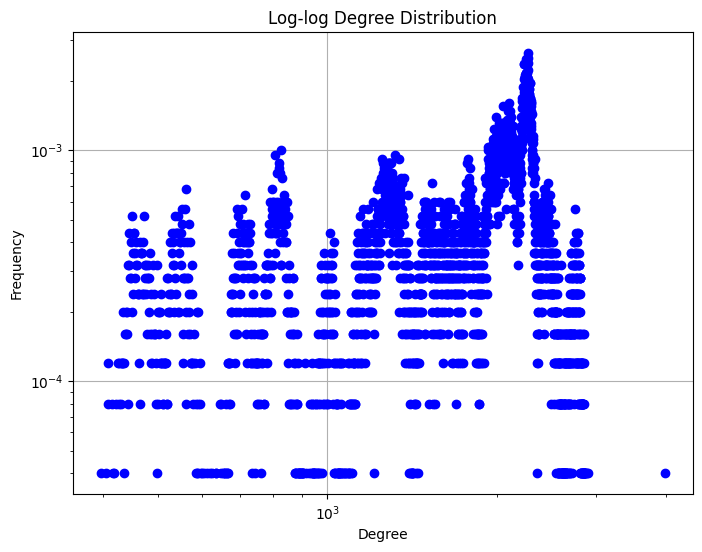

In [3]:
graph = affiliationG(n, m, 0.75, c, 0.05, s)
net_analyzer = Analyzer(graph)
net_analyzer.get_degree_distribution().show()

In [9]:
print("Edges: ", graph.number_of_edges())

Edges:  22808891


As we can see, the scale of the degrees is similar and so it is the number of edges, also the degree distribution has a similar shape. Nevertheless at each run the results of the algorithm are slightly different, due to randomization.

If we apply the Louvain algorithm to this graph we obtain:

In [11]:
print("Number of communities: ", sum(1 for _ in nx.algorithms.community.louvain_communities(graph)))

Number of communities:  4


The diameter is:

In [5]:
print('Diameter: ', stream_diam(graph))

Diameter:  3


The number of connected components is:

In [10]:
cc = nx.algorithms.components.connected_components(graph)
print("Number of connected components: ", sum(1 for _ in cc))
for c in cc:
    print("Size of connected component: ", len(c))

Number of connected components:  1


The clustering coefficient is <b>0.1</b>, we computed it running a notebook on Kaggle.